# ML Models
---

## Libraries

In [89]:
import pandas as pd
import numpy as np

import warnings 
warnings.filterwarnings("ignore")

import re

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(palette="muted")

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from xgboost import XGBRegressor


from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve

import matplotlib.pyplot as plt


from scipy.stats import bootstrap

---
## Load data

In [90]:
# Original dataset after ETL
df = pd.read_csv('..\\datasets\\2. Processed Dataset\\result.csv')
df = df.drop(columns=["id"], errors="ignore")
# Normalized and PCA dataset + One-Hotenconded
df_pca = pd.read_csv('..\\datasets\\2. Processed Dataset\\pca_result.csv')

---
# Compute Metrics

In [91]:
def compute_metrics(y_true, y_pred):
    return {
        "MAE": f"{mean_absolute_error(y_true, y_pred):.2f}",
        "RMSE": f"{root_mean_squared_error(y_true, y_pred):.2f}",
        "%RMSE": f"{(root_mean_squared_error(y_true, y_pred) / y_true.mean()) * 100 :.2f}",
        "R²": f"{r2_score(y_true, y_pred):.2f}"
    }

---
## First approach models training

In [92]:
# Split of the dataset into features and target
X = df_pca
y = df['Salary'] 

# Split data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42) # 25% test

# Standardize Salary
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

# Initialize and train models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}


In [93]:
results = {}
for name, model in models.items():
    model.fit(X_train, y_train_scaled)
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    results[name] = compute_metrics(y_test, y_pred)

# Mostrar resultados en DataFrame
df_results = pd.DataFrame(results).T
df_results

,MAE,RMSE,%RMSE,R²
Linear Regression,11927.44,16714.94,17.10,0.89
Random Forest,11653.30,18545.28,18.98,0.86
XGBoost,12682.65,20772.11,21.26,0.83
Neural Network,11377.02,16100.92,16.48,0.90


---
### Model Hyperparameter Tunning with Grid Search

In [94]:
# Hyperparameter grids
param_grids = {
    "Linear Regression": {},
    "Random Forest": {
        "n_estimators": [100, 200, 300],
        "max_depth": [2, 4, 8, 10, 20, None],
        "min_samples_split": [2, 5, 10, 20]  
    },
    "XGBoost": {
        "n_estimators": [50, 100, 200],
        "max_depth": [3, 6, 10],
        "learning_rate": [0.01, 0.1, 0.2],
    },
    "Neural Network": {
        'hidden_layer_sizes': [(64,), (128, 64), (64, 32)],
        'alpha': [0.0001, 0.001, 0.01, 0.1],
        'learning_rate_init': [0.001, 0.01, 0.1]
    }
}

# Initialize models
models = {
    "Linear Regression":LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "Neural Network": MLPRegressor(max_iter=500, random_state=42)
}

In [95]:
# Train models with hyperparameter tuning
best_models = {}
for name, model in models.items():
    if name in param_grids:
        search = GridSearchCV(model, param_grids[name], cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
        search.fit(X_train, y_train_scaled)
        best_models[name] = search.best_estimator_
        print(f"✅ Best params for {name}: {search.best_params_}")
    else:
        model.fit(X_train, y_train_scaled)
        best_models[name] = model

# Compute and display model metrics
for name, model in best_models.items():
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    results[name] = compute_metrics(y_test, y_pred)

df_results = pd.DataFrame(results).T
df_results

✅ Best params for Linear Regression: {}
✅ Best params for Random Forest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 300}
✅ Best params for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
✅ Best params for Neural Network: {'alpha': 0.001, 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.01}


,MAE,RMSE,%RMSE,R²
Linear Regression,11927.44,16714.94,17.10,0.89
Random Forest,11355.48,18359.71,18.79,0.87
XGBoost,12235.51,18555.69,18.99,0.86
Neural Network,10978.55,15604.75,15.97,0.90


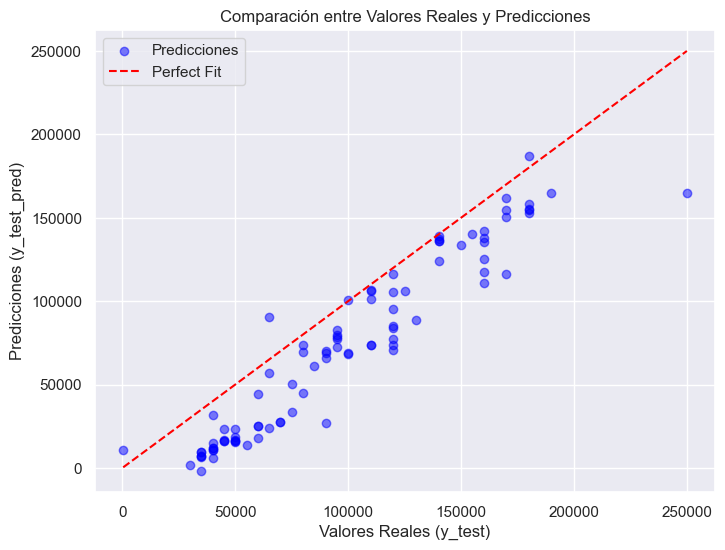

In [101]:
# Obtener predicciones escaladas
y_test_pred_scaled = best_models["Neural Network"].predict(X_test)

# Aplicar transformación inversa
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).ravel()

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5, color='blue', label="Predicciones")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label="Perfect Fit")
plt.xlabel("Valores Reales (y_test)")
plt.ylabel("Predicciones (y_test_pred)")
plt.title("Comparación entre Valores Reales y Predicciones")
plt.legend()
plt.show()

---
## Overfitting Evaluation

### Compare Training vs. Test Performance

In [97]:
# Evaluatiing models
def evaluate_models(models, X_train, y_train, X_test, y_test, scaler_y):
    results = []  
    for name, model in models.items():
        y_train_pred_scaled = model.predict(X_train)
        y_test_pred_scaled = model.predict(X_test)

        # Inverse scale predictions
        y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).ravel()
        y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).ravel()

        # Compute training and test metrics
        train_metrics = compute_metrics(y_train, y_train_pred)
        test_metrics = compute_metrics(y_test, y_test_pred)

        # Append results
        results.append({
            "Model": name,
            "Train_R²": train_metrics["R²"],
            "Test_R²": test_metrics["R²"],
            "Train_RMSE": train_metrics["RMSE"],
            "Test_RMSE": test_metrics["RMSE"],
            "Train_MAE": train_metrics["MAE"],
            "Test_MAE": test_metrics["MAE"],
            "Train_%RMSE": train_metrics["%RMSE"],
            "Test_%RMSE": test_metrics["%RMSE"]
        })

    # DataFrame
    df_results = pd.DataFrame(results)
    return df_results

# Apply this function to all trained models
df_results = evaluate_models(best_models, X_train, y_train, X_test, y_test, scaler_y)
df_results

,Model,Train_R²,Test_R²,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE,Train_%RMSE,Test_%RMSE
0,Linear Regression,0.93,0.89,12592.29,16714.94,9182.55,11927.44,12.39,17.10
1,Random Forest,0.98,0.87,6876.53,18359.71,4519.51,11355.48,6.76,18.79
2,XGBoost,0.98,0.86,6678.56,18555.69,4651.30,12235.51,6.57,18.99
3,Neural Network,0.95,0.90,10999.05,15604.75,7908.52,10978.55,10.82,15.97


### Cross-Validation

In [98]:
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

def cross_validate_models(models, X, y, cv=5):
    results = []

    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

    for name, model in models.items():
        scores = cross_val_score(model, X, y_scaled, cv=cv, scoring='r2', n_jobs=-1)
        
        # Append results
        results.append({
            "Model": name,
            "CV_Mean_R²": round(scores.mean(), 2),
            "CV_Std_R²": round(scores.std(), 2)
        })

    # DataFrame
    df_cv_results = pd.DataFrame(results)
    return df_cv_results

# Apply this function to all trained models
df_cv_results = cross_validate_models(best_models, X, y, cv=5)
df_cv_results

,Model,CV_Mean_R²,CV_Std_R²
0,Linear Regression,0.90,0.05
1,Random Forest,0.89,0.07
2,XGBoost,0.90,0.06
3,Neural Network,0.91,0.04


### Conclusions
- Linear Regression
    - Train R²: 0.92 | Test R²: 0.93 - Train and Test R² are close what suggest is doing a good generalization.
    - RMSE values are also close → No large performance drop.
    - Cross-validation confirms stability (0.90 ± 0.05)
    
- Random Forest: 
    - Train R²: 0.97 | Test R²: 0.93 - R2 Train is much grater than Test R2, the model is overfitting.
    - Train RMSE (8432.13) vs Test RMSE (12637.87) - Large gap suggests overfitting
    
- XGBoost
    - Train R²: 0.98 | Test R²: 0.94 and Train RMSE: 7306.06 | Test RMSE: 12102.86 the model is overfitting.
    - Cross-validation is stable (0.90 ± 0.05)
    - Second best model with a slight overfitting bus stable performance.

- Neural Network:
    - Train R²: 0.95 | Test R²: 0.96 and Train RMSE: 10943.24 | Test RMSE: 9880.52 shows a balance model and no major overfitting despite being a more complex model.
    - Cross-Validation shows highest mean R² (0.92) with lowest variance (±0.03) suggesting a strong generalization to unseen data.
    - Best overall model

In [102]:
# Bootstrap metrics and resample number
boot_metrics = {"MAE": [], "RMSE": [], "R²": []}
num_bootstrap = 1000

# Bootstrap loop

for _ in range(num_bootstrap):
    indices = np.random.choice(len(y_test), size=len(y_test), replace=True)
   
    y_test_sample = y_test.iloc[indices]

    y_pred_scaled = best_models["Neural Network"].predict(X_test.iloc[indices]) 
    y_pred_sample = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

    boot_metrics["MAE"].append(mean_absolute_error(y_test_sample, y_pred_sample))
    boot_metrics["RMSE"].append(root_mean_squared_error(y_test_sample, y_pred_sample))
    boot_metrics["R²"].append(r2_score(y_test_sample, y_pred_sample))

ci_95 = {metric: (np.percentile(values, 2.5), np.percentile(values, 97.5)) for metric, values in boot_metrics.items()}
ci_95


{'MAE': (23193.23519734433, 28890.572871917),
 'RMSE': (26352.412406106687, 33202.06515806867),
 'R²': (0.5375846715015753, 0.7228100968077866)}

In [100]:
# Bootstrap metrics and resample number
boot_metrics = {"MAE": [], "RMSE": [], "R²": []}
num_bootstrap = 1

# Bootstrap loop

for _ in range(num_bootstrap):
    indices = np.random.choice(len(y_test), size=len(y_test), replace=True)
    
    y_test_sample = y_test.iloc[indices]
    y_pred_scaled = best_models["Neural Network"].predict(X_test.iloc[indices])  # <-- USAR .iloc[]
    
    y_pred_sample = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

    boot_metrics["MAE"].append(mean_absolute_error(y_test_sample, y_pred_sample))
    boot_metrics["RMSE"].append(root_mean_squared_error(y_test_sample, y_pred_sample, squared=False))
    boot_metrics["R²"].append(r2_score(y_test_sample, y_pred_sample))

ci_95 = {metric: (np.percentile(values, 2.5), np.percentile(values, 97.5)) for metric, values in boot_metrics.items()}

print("95% Confidence Intervals:", ci_95)

for _ in range(num_bootstrap):
    y_pred_scaled = best_models["Neural Network"].predict(X_test.iloc[indices])

    print("Shape antes de inversa:", y_pred_scaled.shape)
    y_pred_sample = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    print("Shape después de inversa:", y_pred_sample.shape)

    print(f"Min y_pred_sample: {y_pred_sample.min()}, Max y_pred_sample: {y_pred_sample.max()}")
    print(f"Min y_test_sample: {y_test_sample.min()}, Max y_test_sample: {y_test_sample.max()}")

    indices = np.random.choice(len(y_test), size=len(y_test), replace=True)
    y_test_sample = y_test.iloc[indices]  # index selection
    y_pred_sample = scaler_y.inverse_transform(best_models["Neural Network"].predict(X_test.iloc[indices]).reshape(-1, 1)).ravel()
    
    # Guardar métricas
    boot_metrics["MAE"].append(mean_absolute_error(y_test_sample, y_pred_sample))
    boot_metrics["RMSE"].append(root_mean_squared_error(y_test_sample, y_pred_sample))
    boot_metrics["R²"].append(r2_score(y_test_sample, y_pred_sample))

# Calculate 95% confidence intervals
ci_95 = {metric: (np.percentile(values, 2.5), np.percentile(values, 97.5)) for metric, values in boot_metrics.items()}

# Convertir resultados en DataFrame
df_ci_95 = pd.DataFrame(ci_95, index=["Lower Bound", "Upper Bound"]).T

# Mostrar resultados
df_ci_95

TypeError: got an unexpected keyword argument 'squared'

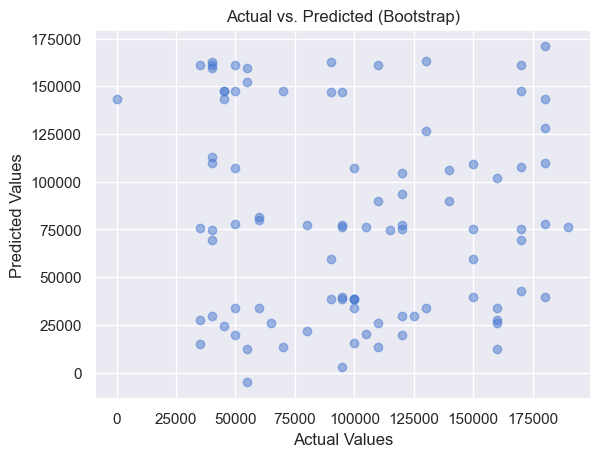

In [ ]:
plt.scatter(y_test, y_pred_sample, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted (Bootstrap)")
plt.show()

In [ ]:
y_pred_full = best_models["Neural Network"].predict(X_test)
y_pred_full = scaler_y.inverse_transform(y_pred_full.reshape(-1, 1)).ravel()

print("R² en Test Set Completo:", r2_score(y_test, y_pred_full))

R² en Test Set Completo: 0.7707305637008757
